#### Imports

In [205]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.image import imread
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [206]:
data_dir = './../images/valid_images'

In [207]:
image_file_names = os.listdir(data_dir)

#### Analyze images and normalize class label

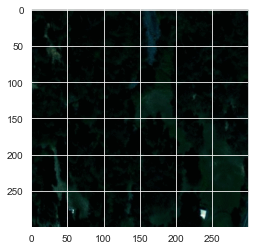

In [208]:
test_image = imread(f'{data_dir}/{image_file_names[13290]}')
plt.imshow(test_image)

In [209]:
test_image.shape

(300, 300, 4)

In [210]:
test_image[:, :, 0]

array([[0.00392157, 0.01176471, 0.01176471, ..., 0.01568628, 0.07058824,
        0.03921569],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.01568628, 0.03921569,
        0.03529412],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.01568628, 0.03921569,
        0.03529412],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.04313726, 0.05098039,
        0.01568628],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.07450981, 0.04313726,
        0.01568628],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.07450981, 0.01960784,
        0.01568628]], dtype=float32)

In [211]:
image_file_names[0]

'WA_total_opportunity_1001.TIF_10477_0.0.png'

In [212]:
regex = re.compile('_([\d.e-]+)\.png')
regex.findall(image_file_names[0])[0]

'0.0'

In [213]:
image_dicts = []
length = len(image_file_names)
count = 1
for image_name in image_file_names:
    print(f'\r{count}/{length}', end='')
    row = {'name': image_name, 'value': float(regex.findall(image_name)[0])}
    image_dicts.append(row)
    count += 1
image_df = pd.DataFrame(image_dicts)

29693/29693

In [214]:
image_df

,name,value
0,WA_total_opportunity_1001.TIF_10477_0.0.png,0.0
1,WA_total_opportunity_1001.TIF_10652_0.0.png,0.0
2,WA_total_opportunity_1001.TIF_1075_0.0.png,0.0
3,WA_total_opportunity_1001.TIF_107_0.0.png,0.0
4,WA_total_opportunity_1001.TIF_11115_0.0.png,0.0
...,...,...
29688,WA_total_opportunity_999.TIF_9001_0.0.png,0.0
29689,WA_total_opportunity_999.TIF_9280_0.0.png,0.0
29690,WA_total_opportunity_999.TIF_950_0.0.png,0.0
29691,WA_total_opportunity_999.TIF_9571_0.0.png,0.0


In [215]:
image_df['value']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
29688    0.0
29689    0.0
29690    0.0
29691    0.0
29692    0.0
Name: value, Length: 29693, dtype: float64

In [216]:
image_df['original_value'] = np.divide(np.multiply(54130, image_df['value']), np.add(image_df['value'], 1))
image_df['norm_value'] = np.divide(image_df['original_value'], 54130)
image_df.iloc[13290]

name              WA_total_opportunity_224.TIF_3331_0.0.png
value                                                   0.0
original_value                                          0.0
norm_value                                              0.0
Name: 13290, dtype: object

In [229]:
image_datagen = ImageDataGenerator(
    # horizontal_flip=True,
    # vertical_flip=True,
    validation_split=0.3
)

train_generator = image_datagen.flow_from_dataframe(
    dataframe=image_df,
    directory=data_dir,
    target_size=(300, 300),
    x_col='name',
    y_col='norm_value',
    color_mode='rgb',
    batch_size=2,
    seed=42,
    class_mode='raw',
    subset='training'
)

test_generator = train_generator = image_datagen.flow_from_dataframe(
    dataframe=image_df,
    directory=data_dir,
    target_size=(300, 300),
    x_col='name',
    y_col='norm_value',
    color_mode='rgb',
    batch_size=1,
    seed=42,
    class_mode='raw',
    subset='validation'
)

Found 20786 validated image filenames.
Found 8907 validated image filenames.


#### Train model

In [230]:
model = Sequential()

# model.add(Conv2D(filters=32, kernel_size=(30,30),input_shape=(300, 300, 3), activation='relu',))
# model.add(MaxPooling2D(pool_size=(25, 25)))

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(300, 300, 3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(300, 300, 3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(300, 300, 3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

# model.add(Dense(2048, activation = 'relu'))
#
# model.add(Dense(1024, activation = 'relu'))

model.add(Dense(128, activation = 'relu'))

# model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [231]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 78400)           

In [232]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples,
    validation_data=test_generator,
    validation_steps=test_generator.samples,
    epochs=6
)

Epoch 1/6
4306/8907 [=============>................] - ETA: 2:00 - loss: 2.4325 - accuracy: 0.8270

KeyboardInterrupt: 